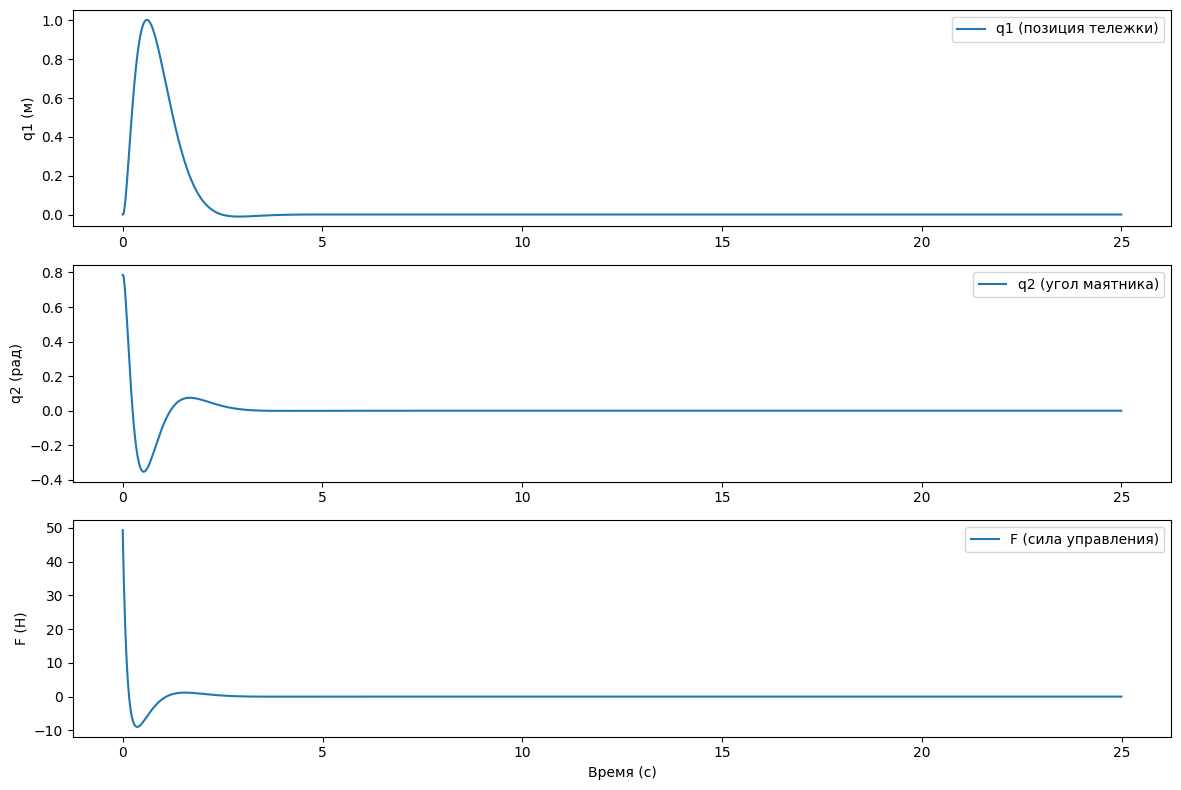

In [16]:
import numpy as np
import scipy.linalg
import matplotlib.pyplot as plt

# Параметры системы
m1 = 1.0 # масса тележки, кг
m2 = 0.3 # масса маятника, кг
l = 0.5 # длина маятника, м
g = 9.81 # ускорение свободного падения, м/с^2
I = 0.006 # момент инерции маятника, кг*м^2

# Матрицы состояния (линеаризация вокруг вертикального положения)
A = np.array([
 [0, 1, 0, 0],
 [0, 0, -m2 * g / m1, 0],
 [0, 0, 0, 1],
 [0, 0, (m1 + m2) * g / (l * m1), 0]
])

B = np.array([
 [0],
 [1 / m1],
 [0],
 [-1 / (l * m1)]
])

# Квадратичные матрицы для LQR
Q = np.diag([10, 1, 10, 1]) # штраф за отклонение состояния
R = np.array([[0.1]]) # штраф за усилие

# Решение уравнения Риккати
P = scipy.linalg.solve_continuous_are(A, B, Q, R)

# Вычисление матрицы управления
K = np.linalg.inv(R) @ (B.T @ P)

# Имитация системы
dt = 0.01 # шаг времени
T = 25.0 # общее время моделирования
N = int(T / dt) # количество шагов

# Начальное состояние [q1, q1_dot, q2, q2_dot]
x = np.array([0.0, 0.0, np.pi / 4, 0.0]) # тележка в покое, маятник наклонен
trajectory = [x]

# Управляющее воздействие и состояние системы
u_history = []

for _ in range(N):
 # Управление (feedback control)
 u = -K @ x
 u_history.append(u)

 # Обновление состояния системы (линейная модель)
 dx = A @ x + B.flatten() * u
 x = x + dx * dt
 trajectory.append(x)

trajectory = np.array(trajectory)
u_history = np.array(u_history)

# Построение графиков
time = np.linspace(0, T, N + 1)

plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
plt.plot(time, trajectory[:, 0], label="q1 (позиция тележки)")
plt.ylabel("q1 (м)")
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(time, trajectory[:, 2], label="q2 (угол маятника)")
plt.ylabel("q2 (рад)")
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(time[:-1], u_history, label="F (сила управления)")
plt.xlabel("Время (с)")
plt.ylabel("F (Н)")
plt.legend()

plt.tight_layout()
plt.show()

Алгоритм I не сошёлся до заданной точности.


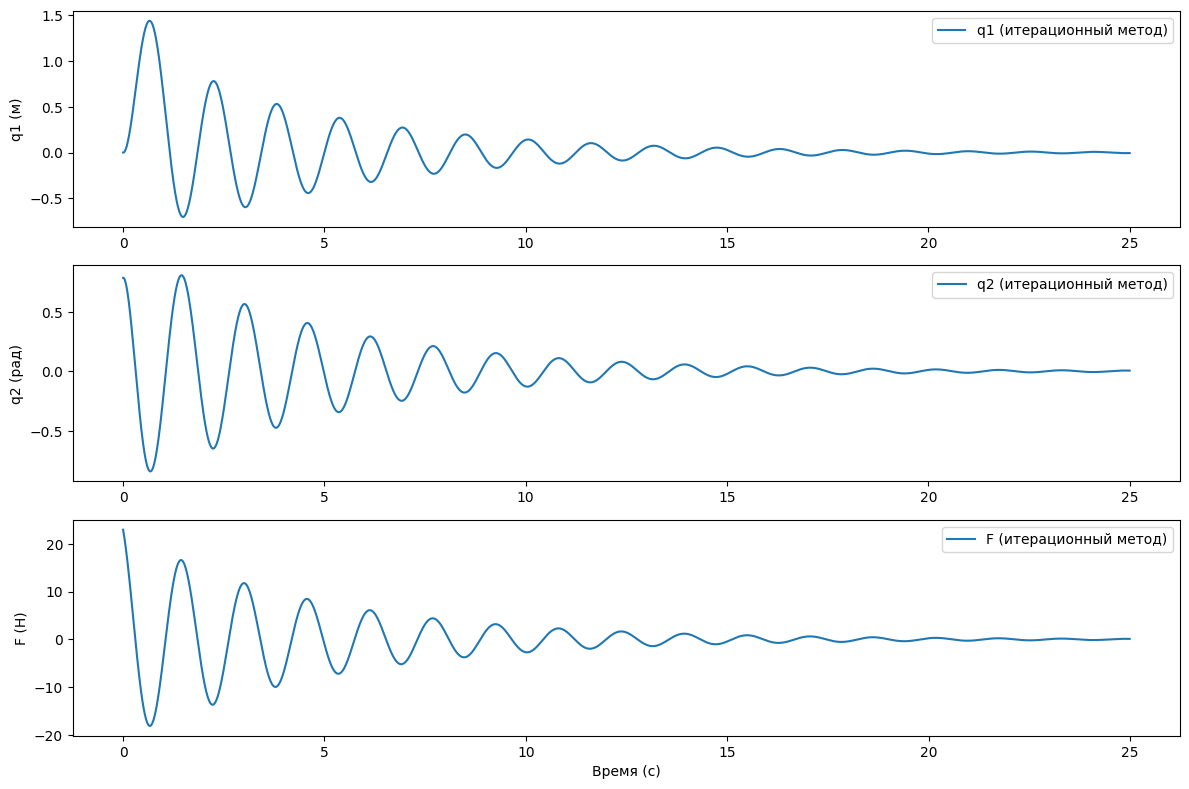

In [17]:
# Алгоритм I: Итерационный подход к решению уравнения Гамильтона-Якоби-Беллмана

# Зададим начальную аппроксимацию управления u^0(t) (нулевая стратегия управления)
K_initial = np.zeros_like(K)  # начальная матрица управления
K_iter = K_initial.copy()

# Параметры итераций
max_iter = 50  # максимальное число итераций
tolerance = 1e-4  # точность сходимости
converged = False

# Матрица стоимости начальной стратегии
P_iter = np.eye(A.shape[0])  # начальное приближение стоимости

# Итеративный процесс
for iteration in range(max_iter):
    # Вычисляем новое управление на основе текущей матрицы стоимости
    K_new = np.linalg.inv(R) @ (B.T @ P_iter)

    # Обновляем уравнение Риккати
    P_new = scipy.linalg.solve_continuous_are(A - B @ K_new, B, Q, R)

    # Проверяем сходимость
    if np.max(np.abs(K_new - K_iter)) < tolerance:
        converged = True
        break

    # Обновляем значения для следующей итерации
    K_iter = K_new.copy()
    P_iter = P_new.copy()

if converged:
    print(f"Алгоритм I (итерации ГЯБ) сошёлся за {iteration + 1} итераций.")
else:
    print("Алгоритм I не сошёлся до заданной точности.")

# Проведение симуляции с итерационным управлением
x_iter = np.array([0.0, 0.0, np.pi / 4, 0.0])
trajectory_iter = [x_iter]
u_history_iter = []

for _ in range(N):
    # Управление через итерационный метод
    u = -K_iter @ x_iter
    u_history_iter.append(u)

    # Обновление состояния системы
    dx = A @ x_iter + B.flatten() * u
    x_iter = x_iter + dx * dt
    trajectory_iter.append(x_iter)

trajectory_iter = np.array(trajectory_iter)
u_history_iter = np.array(u_history_iter)

# Построение графиков для итерационного метода
plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
plt.plot(time, trajectory_iter[:, 0], label="q1 (итерационный метод)")
plt.ylabel("q1 (м)")
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(time, trajectory_iter[:, 2], label="q2 (итерационный метод)")
plt.ylabel("q2 (рад)")
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(time[:-1], u_history_iter, label="F (итерационный метод)")
plt.xlabel("Время (с)")
plt.ylabel("F (Н)")
plt.legend()

plt.tight_layout()
plt.show()

Ошибка аппроксимации управления (MSE): 0.0000


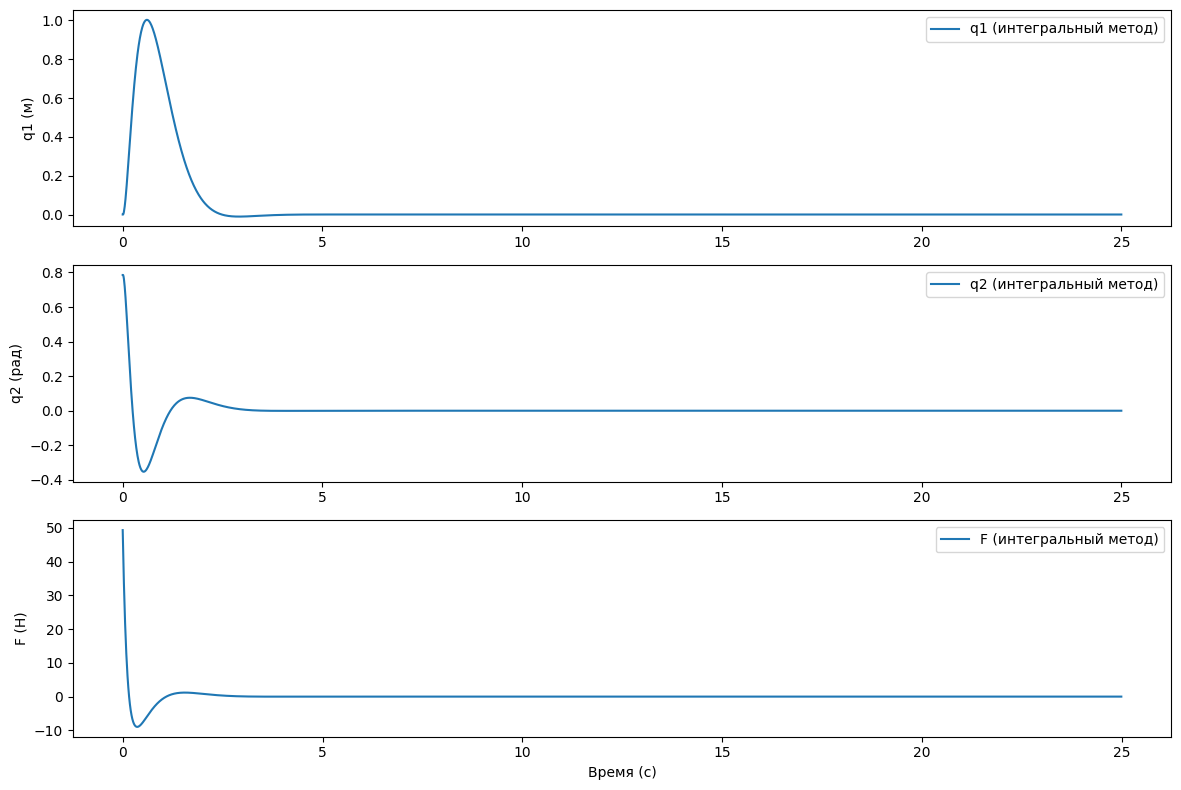

In [18]:
# Алгоритм II: Интегральное обучение на основе траекторий системы
# Генерация данных для обучения
x_data = []  # траектории состояния
u_data = []  # соответствующие управляющие воздействия

# Генерация нескольких случайных начальных состояний
num_trajectories = 20
for _ in range(num_trajectories):
    x_state = np.random.uniform(low=-1.0, high=1.0, size=A.shape[0])  # случайное состояние
    for _ in range(N):
        u_control = -K @ x_state  # текущее управление
        x_data.append(x_state)
        u_data.append(u_control)

        dx = A @ x_state + B.flatten() * u_control
        x_state = x_state + dx * dt

# Конвертация в массивы NumPy
x_data = np.array(x_data)
u_data = np.array(u_data)

# Обучение линейной регрессии для аппроксимации управления
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(x_data, u_data)

# Проверка качества аппроксимации управления
u_pred = lin_reg.predict(x_data)
mse = np.mean((u_pred - u_data) ** 2)
print(f"Ошибка аппроксимации управления (MSE): {mse:.4f}")

# Симуляция с интегральным управлением
x_integral = np.array([0.0, 0.0, np.pi / 4, 0.0])
trajectory_integral = [x_integral]
u_history_integral = []

for _ in range(N):
    # Управление через аппроксиматор
    u = lin_reg.predict(x_integral.reshape(1, -1))[0]
    u_history_integral.append(u)

    # Обновление состояния системы
    dx = A @ x_integral + B.flatten() * u
    x_integral = x_integral + dx * dt
    trajectory_integral.append(x_integral)

trajectory_integral = np.array(trajectory_integral)
u_history_integral = np.array(u_history_integral)

# Построение графиков для интегрального метода
plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
plt.plot(time, trajectory_integral[:, 0], label="q1 (интегральный метод)")
plt.ylabel("q1 (м)")
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(time, trajectory_integral[:, 2], label="q2 (интегральный метод)")
plt.ylabel("q2 (рад)")
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(time[:-1], u_history_integral, label="F (интегральный метод)")
plt.xlabel("Время (с)")
plt.ylabel("F (Н)")
plt.legend()

plt.tight_layout()
plt.show()

Ошибка аппроксимации управления (MSE, нейронная сеть): 0.0007


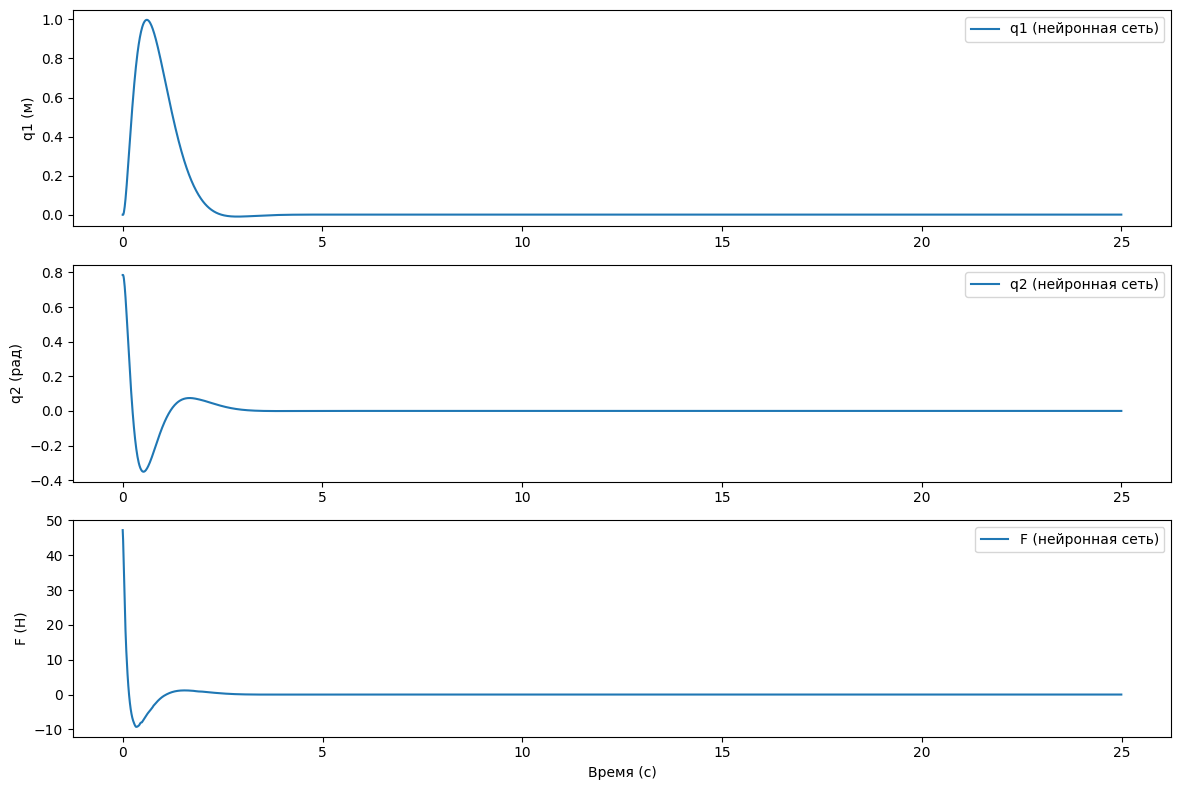

In [19]:
# Алгоритм III: Аппроксимация управления с использованием нейронной сети

from sklearn.neural_network import MLPRegressor

# Создаем модель многослойного перцептрона
nn_model = MLPRegressor(hidden_layer_sizes=(32, 32), max_iter=1000, random_state=42)

# Обучаем модель на тех же данных
nn_model.fit(x_data, u_data.flatten())

# Проверяем качество аппроксимации
u_nn_pred = nn_model.predict(x_data)
mse_nn = np.mean((u_nn_pred - u_data.flatten()) ** 2)
print(f"Ошибка аппроксимации управления (MSE, нейронная сеть): {mse_nn:.4f}")

# Симуляция с управлением через нейронную сеть
x_nn = np.array([0.0, 0.0, np.pi / 4, 0.0])
trajectory_nn = [x_nn]
u_history_nn = []

for _ in range(N):
    # Управление через нейронную сеть
    u = nn_model.predict(x_nn.reshape(1, -1))[0]
    u_history_nn.append(u)

    # Обновление состояния системы
    dx = A @ x_nn + B.flatten() * u
    x_nn = x_nn + dx * dt
    trajectory_nn.append(x_nn)

trajectory_nn = np.array(trajectory_nn)
u_history_nn = np.array(u_history_nn)

# Построение графиков для метода с нейронной сетью
plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
plt.plot(time, trajectory_nn[:, 0], label="q1 (нейронная сеть)")
plt.ylabel("q1 (м)")
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(time, trajectory_nn[:, 2], label="q2 (нейронная сеть)")
plt.ylabel("q2 (рад)")
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(time[:-1], u_history_nn, label="F (нейронная сеть)")
plt.xlabel("Время (с)")
plt.ylabel("F (Н)")
plt.legend()

plt.tight_layout()
plt.show()

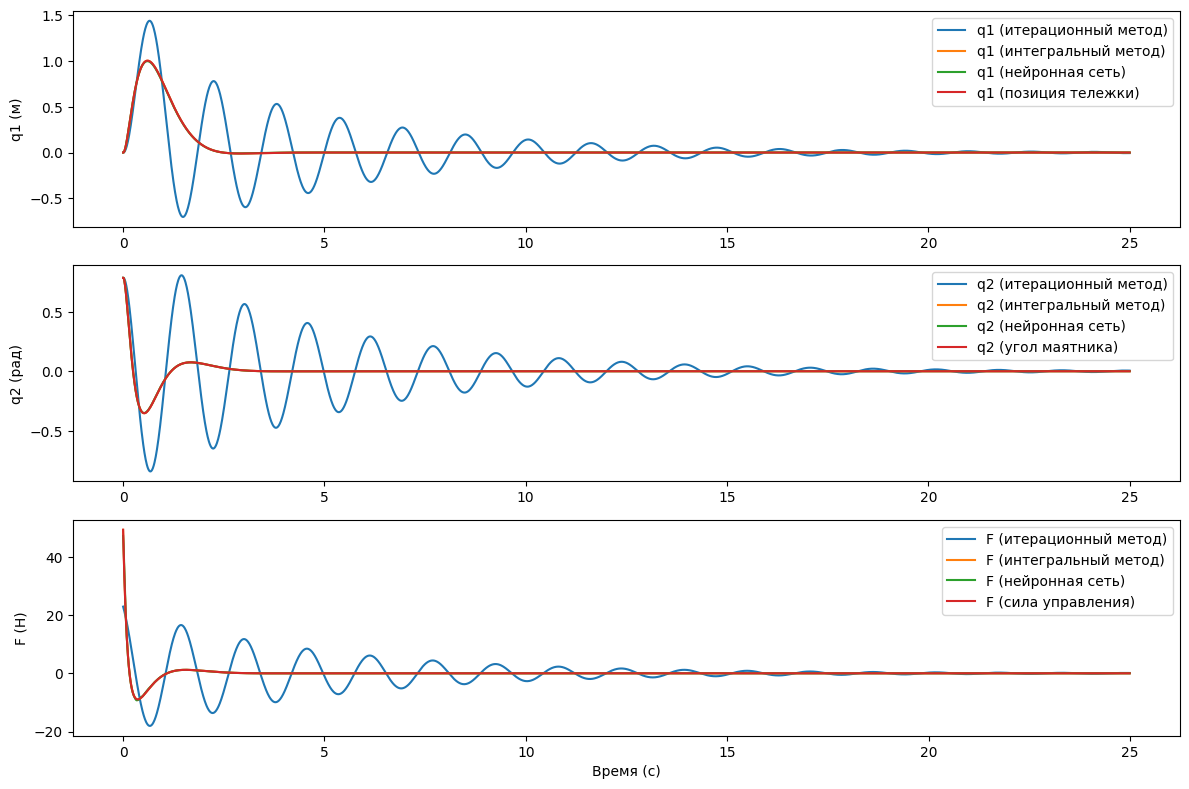

In [20]:
plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
plt.plot(time, trajectory_iter[:, 0], label="q1 (итерационный метод)")
plt.plot(time, trajectory_integral[:, 0], label="q1 (интегральный метод)")
plt.plot(time, trajectory_nn[:, 0], label="q1 (нейронная сеть)")
plt.plot(time, trajectory[:, 0], label="q1 (позиция тележки)")
plt.ylabel("q1 (м)")
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(time, trajectory_iter[:, 2], label="q2 (итерационный метод)")
plt.plot(time, trajectory_integral[:, 2], label="q2 (интегральный метод)")
plt.plot(time, trajectory_nn[:, 2], label="q2 (нейронная сеть)")
plt.plot(time, trajectory[:, 2], label="q2 (угол маятника)")
plt.ylabel("q2 (рад)")
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(time[:-1], u_history_iter, label="F (итерационный метод)")
plt.plot(time[:-1], u_history_integral, label="F (интегральный метод)")
plt.plot(time[:-1], u_history_nn, label="F (нейронная сеть)")
plt.plot(time[:-1], u_history, label="F (сила управления)")
plt.xlabel("Время (с)")
plt.ylabel("F (Н)")
plt.legend()

plt.tight_layout()
plt.show()

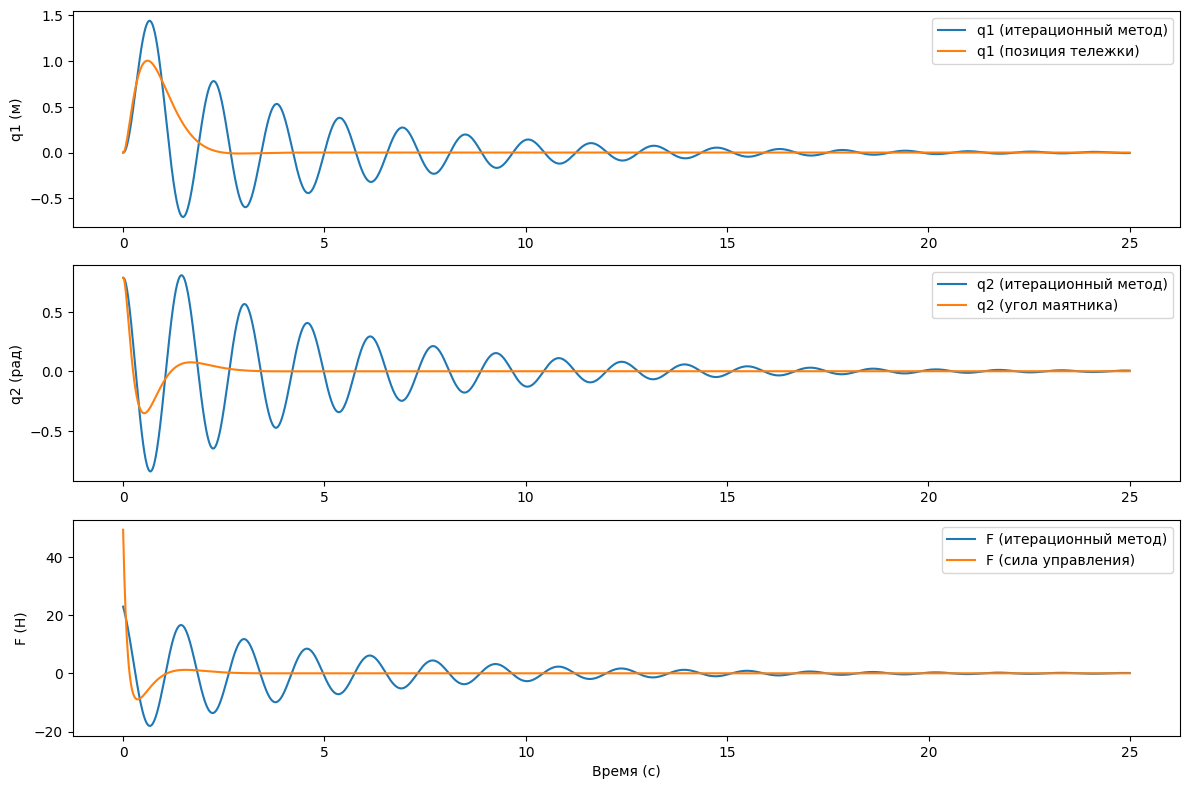

In [21]:
plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
plt.plot(time, trajectory_iter[:, 0], label="q1 (итерационный метод)")
plt.plot(time, trajectory[:, 0], label="q1 (позиция тележки)")
plt.ylabel("q1 (м)")
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(time, trajectory_iter[:, 2], label="q2 (итерационный метод)")
plt.plot(time, trajectory[:, 2], label="q2 (угол маятника)")
plt.ylabel("q2 (рад)")
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(time[:-1], u_history_iter, label="F (итерационный метод)")
plt.plot(time[:-1], u_history, label="F (сила управления)")
plt.xlabel("Время (с)")
plt.ylabel("F (Н)")
plt.legend()

plt.tight_layout()
plt.show()

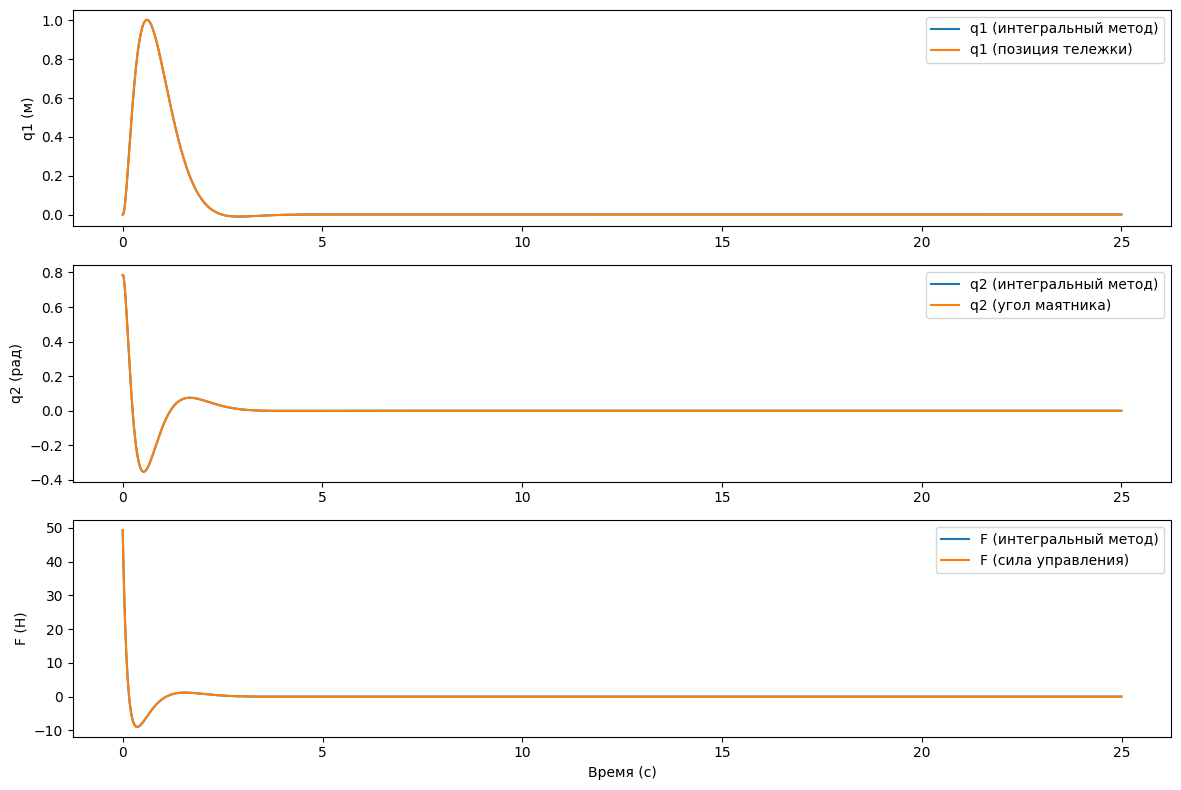

In [22]:
plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
plt.plot(time, trajectory_integral[:, 0], label="q1 (интегральный метод)")
plt.plot(time, trajectory[:, 0], label="q1 (позиция тележки)")
plt.ylabel("q1 (м)")
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(time, trajectory_integral[:, 2], label="q2 (интегральный метод)")
plt.plot(time, trajectory[:, 2], label="q2 (угол маятника)")
plt.ylabel("q2 (рад)")
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(time[:-1], u_history_integral, label="F (интегральный метод)")
plt.plot(time[:-1], u_history, label="F (сила управления)")
plt.xlabel("Время (с)")
plt.ylabel("F (Н)")
plt.legend()

plt.tight_layout()
plt.show()

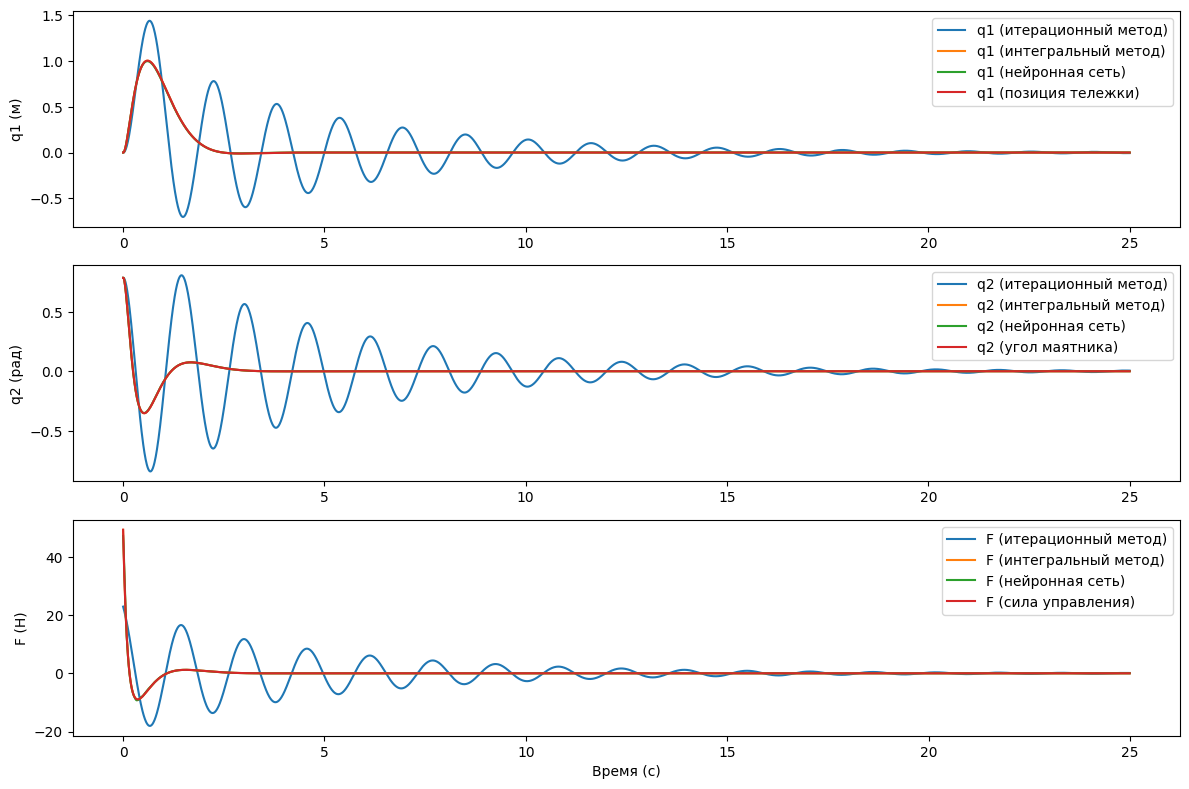

In [23]:
plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
plt.plot(time, trajectory_iter[:, 0], label="q1 (итерационный метод)")
plt.plot(time, trajectory_integral[:, 0], label="q1 (интегральный метод)")
plt.plot(time, trajectory_nn[:, 0], label="q1 (нейронная сеть)")
plt.plot(time, trajectory[:, 0], label="q1 (позиция тележки)")
plt.ylabel("q1 (м)")
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(time, trajectory_iter[:, 2], label="q2 (итерационный метод)")
plt.plot(time, trajectory_integral[:, 2], label="q2 (интегральный метод)")
plt.plot(time, trajectory_nn[:, 2], label="q2 (нейронная сеть)")
plt.plot(time, trajectory[:, 2], label="q2 (угол маятника)")
plt.ylabel("q2 (рад)")
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(time[:-1], u_history_iter, label="F (итерационный метод)")
plt.plot(time[:-1], u_history_integral, label="F (интегральный метод)")
plt.plot(time[:-1], u_history_nn, label="F (нейронная сеть)")
plt.plot(time[:-1], u_history, label="F (сила управления)")
plt.xlabel("Время (с)")
plt.ylabel("F (Н)")
plt.legend()

plt.tight_layout()
plt.show()